In [ ]:
# Import all of the necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from statsmodels.tsa.arima.model import ARIMA
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import HRPOpt
from pypfopt.efficient_frontier import EfficientCVaR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Fetch historical stock data for Apple Inc.
tesla = yf.Ticker("TSLA")
tesla_data = tesla.history(period="1d", start="2008-01-01", end="2025-04-07")
print(tesla_data.head())

                               Open      High       Low     Close     Volume  \
Date                                                                           
2010-06-29 00:00:00-04:00  1.266667  1.666667  1.169333  1.592667  281494500   
2010-06-30 00:00:00-04:00  1.719333  2.028000  1.553333  1.588667  257806500   
2010-07-01 00:00:00-04:00  1.666667  1.728000  1.351333  1.464000  123282000   
2010-07-02 00:00:00-04:00  1.533333  1.540000  1.247333  1.280000   77097000   
2010-07-06 00:00:00-04:00  1.333333  1.333333  1.055333  1.074000  103003500   

                           Dividends  Stock Splits  
Date                                                
2010-06-29 00:00:00-04:00        0.0           0.0  
2010-06-30 00:00:00-04:00        0.0           0.0  
2010-07-01 00:00:00-04:00        0.0           0.0  
2010-07-02 00:00:00-04:00        0.0           0.0  
2010-07-06 00:00:00-04:00        0.0           0.0  


In [ ]:
# Calculate the daily percentage change in closing prices to get daily returns
tesla_daily_returns = tesla_data['Close'].pct_change()

# Resample data to monthly frequency, forward fill missing values, and calculate monthly returns
tesla_monthly_returns = tesla_data['Close'].resample('M').ffill().pct_change()

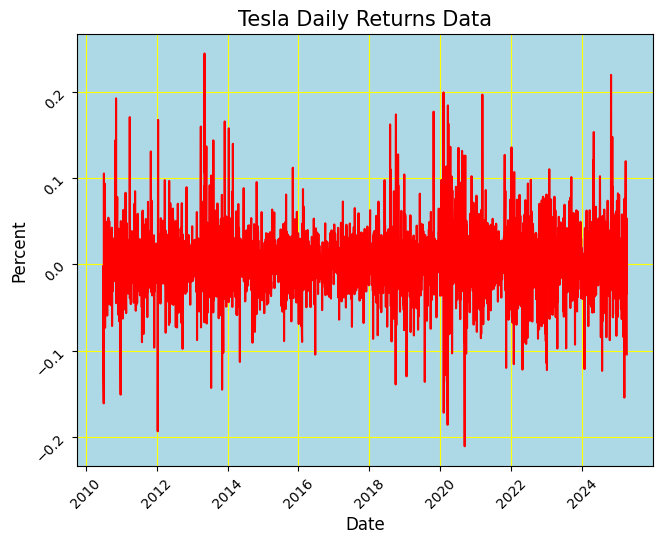

In [ ]:
# Plot a time series plot to show Tesla Daily Return Stocks
fig = plt.figure()
ax1 = fig.add_axes([0.3,0.3,0.9,0.9])
ax1.plot(tesla_daily_returns, color = 'red')
ax1.set_xlabel("Date", fontsize = 12)
ax1.set_ylabel("Percent", fontsize = 12)
ax1.set_title("Tesla Daily Returns Data",fontsize = 15)
plt.xticks(rotation = 45)
plt.yticks(rotation= 45)
ax1.set_facecolor('lightblue')
plt.grid(True, color = 'yellow')
plt.show()

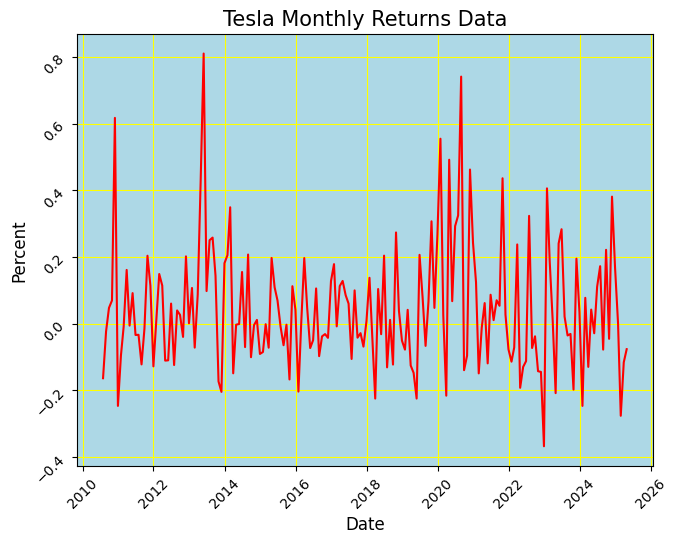

In [ ]:
# Plot a time series plot to show Tesla Monthly Return Stocks
fig = plt.figure()
ax1 = fig.add_axes([0.3,0.3,0.9,0.9])
ax1.plot(tesla_monthly_returns, color = 'red')
ax1.set_xlabel("Date", fontsize = 12, )
ax1.set_ylabel("Percent", fontsize = 12)
ax1.set_title("Tesla Monthly Returns Data", fontsize = 15)
plt.xticks(rotation = 45)
plt.yticks(rotation= 45)
ax1.set_facecolor('lightblue')
plt.grid(True, color = 'yellow')
plt.show()

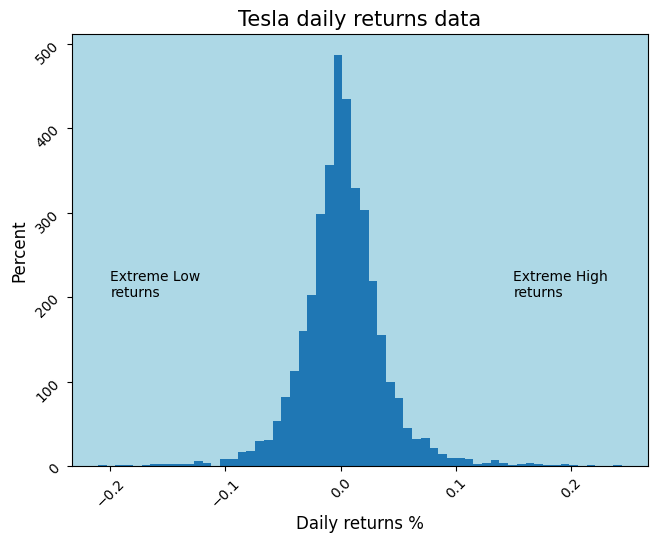

In [ ]:
# Plot a distribution plot of the Tesla Daily Returns Data
fig = plt.figure()
ax1 = fig.add_axes([0.3,0.3,0.9,0.9])

tesla_daily_returns.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %", fontsize = 12)
ax1.set_ylabel("Percent", fontsize = 12)
ax1.set_title("Tesla daily returns data", fontsize = 15)
ax1.text(-0.20,200,"Extreme Low\nreturns")
ax1.text(0.15,200,"Extreme High\nreturns")
plt.xticks(rotation = 45)
plt.yticks(rotation= 45)
ax1.set_facecolor('lightblue')
plt.show()

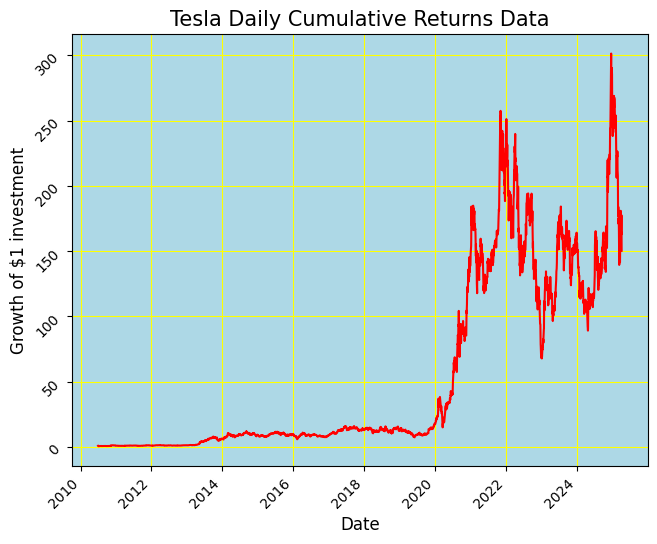

In [ ]:
# Plot a time series plot to show Tesla Daily Cumulative Return Stocks
tesla_cum_returns = (tesla_daily_returns + 1).cumprod()

fig = plt.figure()
ax1 = fig.add_axes([0.3,0.3,0.9,0.9])
tesla_cum_returns.plot(color = 'red')
ax1.set_xlabel("Date", fontsize = 12)
ax1.set_ylabel("Growth of $1 investment", fontsize = 12)
ax1.set_title("Tesla Daily Cumulative Returns Data", fontsize = 15)
ax1.set_facecolor('lightblue')
plt.xticks(rotation = 45)
plt.yticks(rotation= 45)
plt.grid(True, color = 'yellow')
plt.show()

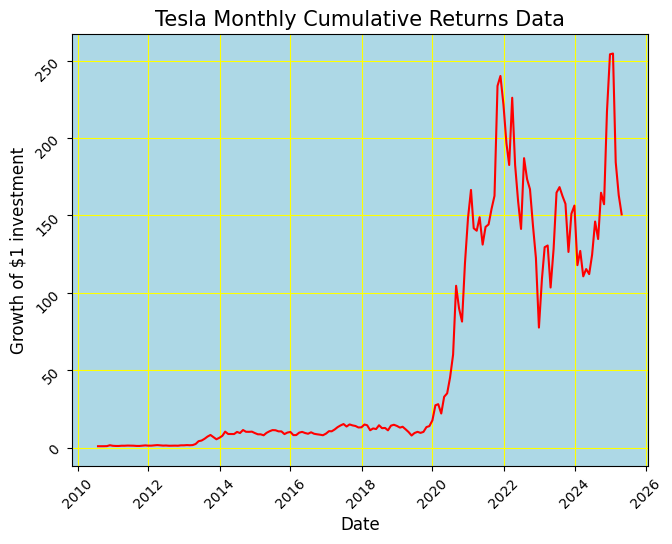

In [ ]:
# Plot a time series plot to show Tesla Monthly Cumulative Return Stocks
fig = plt.figure()
ax1 = fig.add_axes([0.3,0.3,0.9,0.9])
tesla_cum_returns = (tesla_monthly_returns + 1).cumprod()
ax1.plot(tesla_cum_returns, color = 'red')
ax1.set_xlabel("Date", fontsize = 12)
ax1.set_ylabel("Growth of $1 investment", fontsize = 12)
ax1.set_title("Tesla Monthly Cumulative Returns Data", fontsize = 15)
ax1.set_facecolor('lightblue')
plt.xticks(rotation = 45)
plt.yticks(rotation= 45)
plt.grid(True, color = 'yellow')
plt.show()

# Risk Analysis


In [ ]:
# Define parameters for Monte Carlo simulation
# Calculate the average daily return (mean)
mean = np.mean(tesla_daily_returns)

# Calculate the standard deviation of daily returns (volatility)
vol = np.std(tesla_daily_returns)

# Simulate future stock prices using geometric Brownian motion
# Number of simulations to run
simulations = 1500

# Number of trading days to simulate (approximately 1 year)
days = 365

# Time step (1 day)
dt = 1 / 365

# Get the last closing price from the tesla_data DataFrame as the starting price for simulations
S0 = tesla_data['Close'].iloc[-1]

# Create an array to store the simulated prices
simulated_prices = np.zeros((simulations, days))

# Loop through each simulation
for i in range(simulations):
    # Initialize the price list for the current simulation with the starting price
    prices = [S0]
    # Loop through each day within the simulation
    for i in range(days): # Added a nested loop for days

        # Calculate the drift component of the price change
        drift = (mean - 0.5 * vol ** 2) * dt

        # Calculate the random diffusion component of the price change
        diffusion = vol * np.sqrt(dt) * np.random.normal()

        # Calculate the new price using the geometric Brownian motion formula
        price = prices[-1] * np.exp(drift + diffusion)

        # Add the new price to the price list for the current simulation
        prices.append(price)

    # Store the simulated prices for the current simulation in the simulated_prices array
    simulated_prices[i] = prices[1:] # Slice prices to remove initial S0

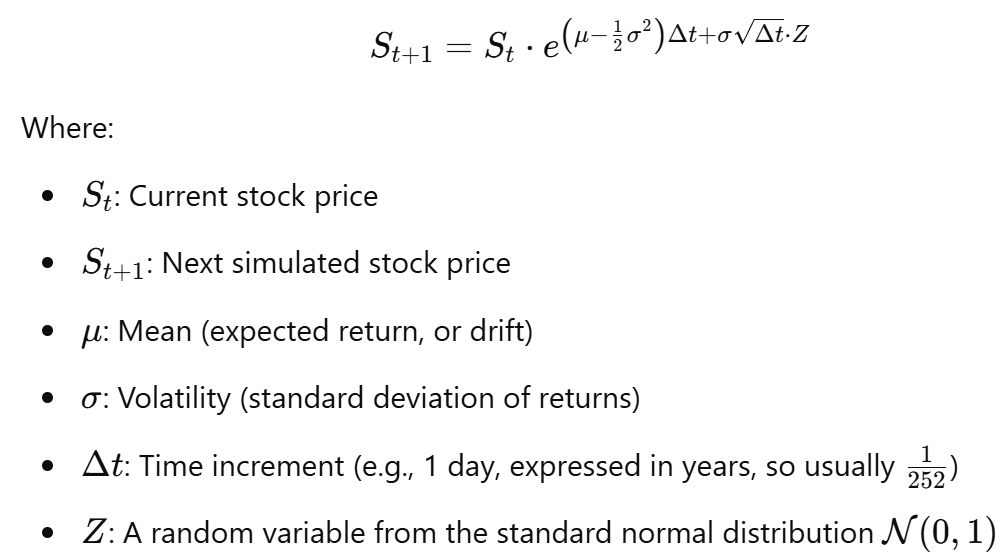

In [ ]:
# Create the Hedge Cost and Expected Loss functions

def calculate_hedge_cost(simulated_prices):

    # Get the initial price for each simulation (first column of the array)
    init_price = simulated_prices[:, 0]

    # Calculate the hedge cost for each simulation (1% of initial price)
    hedge_cost = 0.01 * init_price

    # Calculate the average hedge cost across all simulations
    average_hedge_cost = np.mean(hedge_cost)

    return average_hedge_cost


def calculate_expected_loss(simulated_prices):

    # Calculate the final price for each simulation (last column of the array)
    final_price = simulated_prices[:, -1]

    # Calculate the percentage change from initial to final price for each simulation
    pct_change = (final_price - simulated_prices[:, 0]) / simulated_prices[:, 0]

    # Calculate the average percentage change across all simulations
    avr_pct_change = np.mean(pct_change)

    # Assume expected loss is the average negative percentage change (or 0 if positive)
    expected_loss = -avr_pct_change if avr_pct_change < 0 else 0

    return expected_loss

# ***Average Hedge Cost Function***
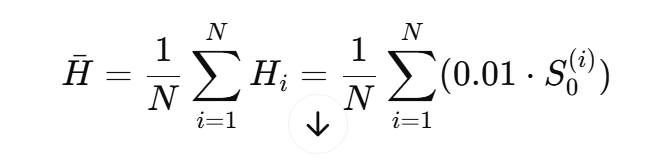

# ***Expected Loss Function***

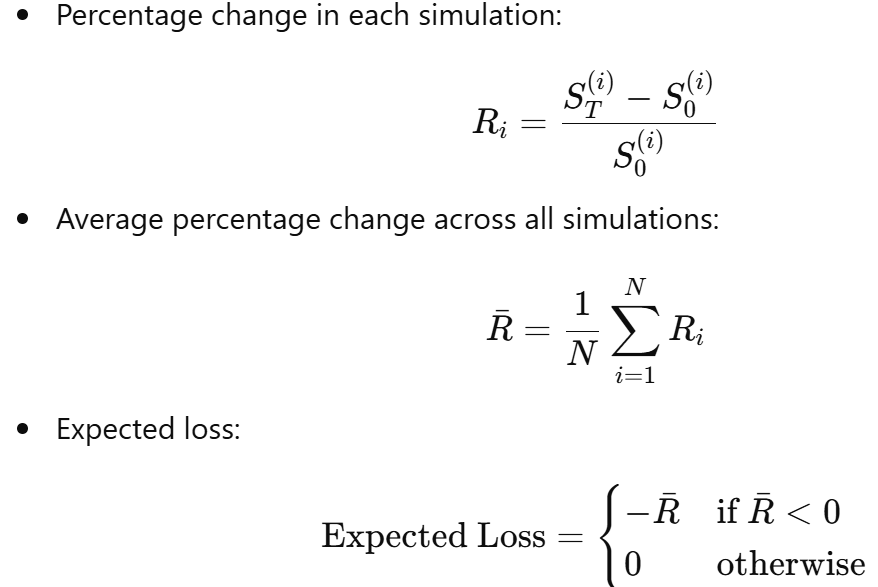

In [ ]:
# Evaluate risk mitigation strategy
hedge_cost = calculate_hedge_cost(simulated_prices)
expected_loss = calculate_expected_loss(simulated_prices)
net_benefit = expected_loss - hedge_cost

if net_benefit > 0:
    print("Implementing the risk mitigation strategy is beneficial.")
else:
    print("The risk mitigation strategy may not be cost-effective.")

The risk mitigation strategy may not be cost-effective.


# Portfolio Optimization

In [ ]:
# Crate a list tickers for your portfolio
tickers = ['TSLA', 'AAPL', 'MSFT']  # Replace with your actual tickers

# Fetch historical data for the portfolio assets
portfolio = yf.download(tickers, start="2008-01-01", end="2025-04-07")['Close']  # Changed to Adj Close

# Calculate the
mu = mean_historical_return(portfolio)
S = CovarianceShrinkage(portfolio).ledoit_wolf()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [ ]:
# Create an EfficientFrontier object
ef = EfficientFrontier(mu, S)

# Calculate portfolio weights that maximize the Sharpe ratio
weights = ef.max_sharpe()

# Clean the weights by rounding off very small values to zero
cleaned_weights = ef.clean_weights()

# Convert the cleaned weights to a dictionary and print them
print(dict(cleaned_weights))

{'AAPL': 0.47301, 'MSFT': 0.17877, 'TSLA': 0.34822}


In [ ]:
# Calculate and display the portfolio's expected return, volatility, and Sharpe ratio
ef.portfolio_performance(verbose=True)

Expected annual return: 27.6%
Annual volatility: 29.8%
Sharpe Ratio: 0.93


(np.float64(0.2762887371743671),
 np.float64(0.29807204485494987),
 np.float64(0.9269193201556921))

In [ ]:
# Fetch the latest prices for the assets in the portfolio
latest_prices = get_latest_prices(portfolio)

# Create a DiscreteAllocation object
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Perform discrete allocation using a greedy algorithm
allocation, leftover = da.greedy_portfolio()

# Print the allocation and leftover funds
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'AAPL': 251, 'TSLA': 145, 'MSFT': 50}
Funds remaining: $7.27


In [ ]:
# Calculate daily percentage change of the portfolio and drop any rows with missing values
returns = portfolio.pct_change().dropna()

In [ ]:
# Create an HRPOpt object
hrp = HRPOpt(returns)

# Calculate the portfolio weights using Hierarchical Risk Parity
hrp_weights = hrp.optimize()

In [ ]:
# Calculate and display portfolio performance based on HRP weights
hrp.portfolio_performance(verbose=True)

# Print the calculated HRP weights in a dictionary format
print(dict(hrp_weights))

Expected annual return: 28.3%
Annual volatility: 24.9%
Sharpe Ratio: 1.14
{'AAPL': np.float64(0.3914959724543379), 'MSFT': np.float64(0.463734663370651), 'TSLA': np.float64(0.14476936417501107)}


In [ ]:
# Create a DiscreteAllocation object for HRP weights
da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value=100000)

# Perform discrete allocation using HRP weights and a greedy algorithm
allocation, leftover = da_hrp.greedy_portfolio()

# Print the discrete allocation and leftover funds for HRP
print("Discrete allocation (HRP):", allocation)
print("Funds remaining (HRP): ${:.2f}".format(leftover))

Discrete allocation (HRP): {'MSFT': 129, 'AAPL': 208, 'TSLA': 60}
Funds remaining (HRP): $31.80


In [ ]:
# Calculate daily percentage change of the portfolio and drop any rows with missing values
returns = portfolio.pct_change().dropna()

# Create an EfficientCVaR object for portfolio optimization based on Conditional Value at Risk (CVaR)
efcvar = EfficientCVaR(mu, returns)

# Calculate portfolio weights that minimize CVaR
efcvar_weights = efcvar.min_cvar()

# Clean the weights by rounding off very small values to zero
cleaned_weights = efcvar.clean_weights()

# Print the cleaned CVaR weights as a dictionary
print(dict(cleaned_weights))

{'AAPL': 0.35778, 'MSFT': 0.64222, 'TSLA': 0.0}


In [ ]:
# Create a DiscreteAllocation object for CVaR weights
dacvar = DiscreteAllocation(efcvar_weights, latest_prices, total_portfolio_value=100000)

# Perform discrete allocation using CVaR weights and a greedy algorithm
allocation, leftover = dacvar.greedy_portfolio()

# Print the discrete allocation and leftover funds for the CVaR portfolio
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

Discrete allocation (CVAR): {'MSFT': 178, 'AAPL': 190}
Funds remaining (CVAR): $156.28


 # Linear Regression


In [ ]:
# Calculate moving averages
tesla_data['MA_10'] = tesla_data['Close'].rolling(window=10).mean()
tesla_data['MA_50'] = tesla_data['Close'].rolling(window=50).mean()

# Drop NaN values
tesla = tesla_data.dropna()

# Define features and target
X = tesla[['Close', 'MA_10', 'MA_50']]
y = tesla['Close'].shift(-1).dropna()
X = X[:-1]

In [ ]:
# Split the dataset into a training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a Linear Regression model object
model = LinearRegression()

# Train the model using the training data (features and target)
model.fit(X_train, y_train)

# Make predictions on the test data using the trained model
predictions = model.predict(X_test)

In [ ]:
# Calculate the Mean Squared Error (MSE) to measure the average squared difference between predicted and actual values
mse = mean_squared_error(y_test, predictions)

# Calculate the R-squared (R²) score to assess the model's goodness of fit (proportion of variance explained)
r2 = r2_score(y_test, predictions)

# Print the calculated MSE and R² values
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 29.76338831990308
R² Score: 0.9975229686664289


In [ ]:
# Set the initial account balance
initial_balance = 25000  # Starting balance in USD

# Initialize the current balance with the initial balance
balance = initial_balance

# Initialize the number of shares held to 0
position = 0  # Number of shares

# Iterate through each data point in the test dataset
for i in range(len(X_test)):
    # Get the current actual price from the test data
    current_price = X_test.iloc[i]['Close']
    # Get the predicted price for the current data point
    predicted_price = predictions[i]

    # Check if the predicted price is higher than the current price and if we have enough balance to buy
    if predicted_price > current_price and balance >= current_price:
        # Buy stock (calculate affordable shares and execute buy order)
        shares_to_buy = int(balance // current_price)  # Buy whole shares only
        if shares_to_buy > 0:  # Ensure we are buying at least one share
            position += shares_to_buy
            balance -= shares_to_buy * current_price
            print(f"Buying {shares_to_buy} shares at {current_price:.2f}")

    # Check if the predicted price is lower than the current price and if we have shares to sell
    elif predicted_price < current_price and position > 0:
        # Sell stock (sell all held shares and update balance)
        balance += position * current_price
        print(f"Selling {position} shares at {current_price:.2f}")
        position = 0

# Calculate the final balance (cash + value of remaining shares)
final_balance = balance + (position * X_test.iloc[-1]['Close'])

# Calculate the total profit (final balance - initial balance)
profit = final_balance - initial_balance

# Print the final balance and profit
print(f"Final balance: ${final_balance:.2f}")
print(f"Profit: ${profit:.2f}")

Buying 1079 shares at 23.17
Selling 1079 shares at 198.84
Buying 16142 shares at 13.29
Selling 16142 shares at 253.87
Buying 2154559 shares at 1.90
Selling 2154559 shares at 135.34
Buying 20868177 shares at 13.97
Buying 1 shares at 12.87
Selling 20868178 shares at 303.08
Buying 2749911866 shares at 2.30
Selling 2749911866 shares at 268.19
Buying 396509683729 shares at 1.86
Selling 396509683729 shares at 262.37
Buying 10577399377717 shares at 9.84
Buying 3 shares at 1.37
Selling 10577399377720 shares at 178.65
Buying 92614881734253 shares at 20.40
Selling 92614881734253 shares at 341.83
Buying 1956082422384289 shares at 16.18
Selling 1956082422384289 shares at 312.47
Buying 281753461655100832 shares at 2.17
Selling 281753461655100832 shares at 212.19
Buying 299825825207934400 shares at 199.40
Selling 299825825207934400 shares at 44.53
Buying 926281750950353408 shares at 14.41
Selling 926281750950353408 shares at 211.88
Buying 14746824698273460224 shares at 13.31
Selling 1474682469827346